#### Import necessary libraries 

In [1]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
# importing voting classifier
from sklearn.ensemble import VotingClassifier
import deepchem as dc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from deepchem import metrics


#### Read in the preprocessed BBB dataset from Adenot paper

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [3]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data preprocessing

In [4]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Optimized Random Forest

In [5]:
# Create a Random Forest Classifier
rf_best = RandomForestClassifier(random_state=0, n_estimators = 100, criterion='gini', max_depth=20)

# Train the model using the training sets
rf_best.fit(X_train,y_train)
y_pred = rf_best.predict(X_test)

#### Optimized SVM

In [6]:
# Create a Support Vector Machine Classifier
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

# Train the model using the training sets
SVM_best.fit(X_train, y_train)
# make predictions for test data
y_pred = SVM_best.predict(X_test)

#### Optimized XGBoost

In [7]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [8]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = xg_best.predict(X_test)

### Ensemble

In [9]:
# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('svm', SVM_best), ('xgb', xg_best), ('rf', rf_best)], voting='soft')
 
# training all the model on the train dataset
final_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
y_pred = final_model.predict(X_test)


### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9618473895582329
Balanced Accuracy: 0.910765306122449
ROC AUC: 0.910765306122449
Precision Score: 0.9590361445783132
Recall Score: 0.995



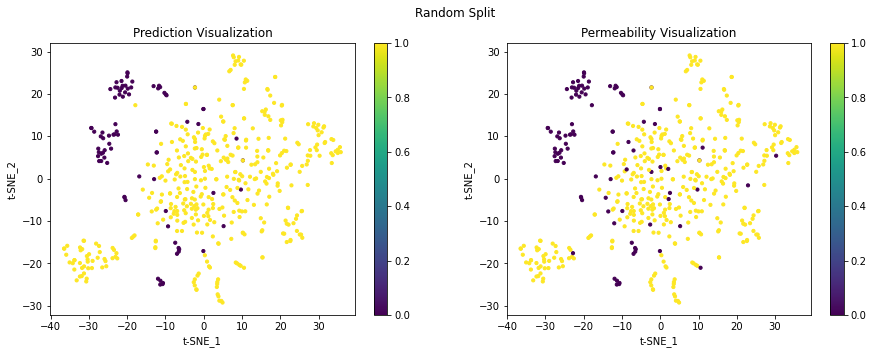

In [10]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split

#### Data preprocessing

In [11]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [12]:
# Train SVM classifier
final_model = final_model.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = final_model.predict(test_scaff.X)

In [13]:
y_pred_scaff_prob = final_model.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
23,CCc1sc2c(c1)C(=NCC(=O)N2C)c1ccccc1Cl,0.999218
51,CN1C[C@H](CSc2ccccn2)C=C2[C@H]1Cc1c[nH]c3cccc2c13,0.999107
147,CC1(CC(=O)N(CN2CCOCC2)C1=O)c1ccccc1,0.998928
67,CN1CCN(CC1)c1cc2c(nn1)Oc1ccccc1N2C,0.998898
149,Clc1ccc(c(c1)Cl)/C(/Cl)=C/n1cncn1,0.998564
...,...,...
230,CC1(C)S[C@@H]2[C@H](NC(=O)C(/N=C/c3occc3)c3ccc...,0.003910
243,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.003467
248,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.001102
247,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000553


### Scaffold Split PCA, DR, and Result Metrics

In [14]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [15]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8614457831325302
Balanced Accuracy: 0.8445945945945945
ROC AUC: 0.8445945945945946
Precision Score: 0.8
Recall Score: 1.0



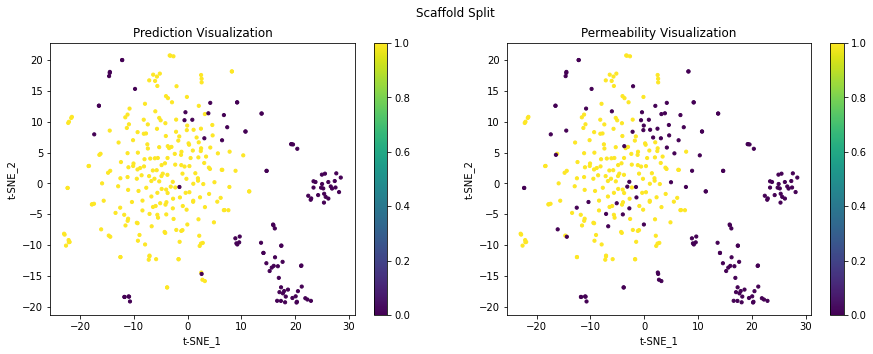

In [16]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)